# A CNN predicting if the nerve is visible or not

In [1]:
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

In [2]:
_d = np.load('../../data_train.npz')
X = _d['X']
Y = _d['Y']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)
#enc = OneHotEncoder()
#Y = enc.fit_transform(Y.reshape(-1, 1)).toarray()

In [3]:
Y_binary

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


array([ 1.,  0.,  1., ...,  0.,  1.,  0.], dtype=float32)

In [4]:
print X.shape
print Y_binary.shape

(5635, 104, 144)
(5635,)


In [5]:
nsamples = X.shape[0]

train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
X_train = X[train_indices][:,None,:,:]
Y_train_binary = Y_binary[train_indices]
Y_train = Y[train_indices]
X_test = X[test_indices][:,None,:,:]
Y_test_binary = Y_binary[test_indices]
Y_test = Y[test_indices]

In [6]:
print X_train.shape
print Y_train_binary.shape
print X_train.min(), X_train.max()

(5071, 1, 104, 144)
(5071,)
0.0 1.0


<matplotlib.colorbar.Colorbar instance at 0x7f764816f680>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


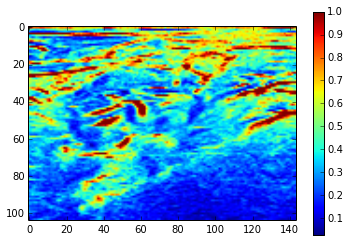

In [7]:
pl.imshow(X_train[0].squeeze())
pl.colorbar()

# Keras model

In [8]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 104, 144)


In [9]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float16'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [10]:
import theano
print theano.config.device

gpu0


In [11]:
input_img = Input(shape=input_shape)
x = Convolution2D(16, 3, 3,border_mode='valid')(input_img)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool1 = Dropout(0.25, name='pool1')(x)

x = Convolution2D(32, 3, 3, border_mode='valid')(pool1)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool2 = Dropout(0.25, name='pool2')(x)

x = Convolution2D(64, 3, 3, border_mode='valid')(pool2)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool3 = Dropout(0.25, name='pool3')(x)

x = Convolution2D(32, 3, 3, border_mode='valid')(pool3)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool4 = Dropout(0.25, name='pool4')(x)

# Since some images have not mask, the hope is that the innermost units capture this
x = Flatten()(pool4)
x = Dense(32)(x)
x = Dense(16)(x)
outpred = Dense(1, activation='sigmoid')(x)

model = Model(input_img, outpred)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(loss='binary_crossentropy',
#              optimizer=rmsprop,
#              metrics=['accuracy'])
#model.compile(loss='binary_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 1, 104, 144) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)    (None, 16, 102, 142)160         input_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)            (None, 16, 102, 142)0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 16, 100, 140)2320        leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [12]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [13]:
def load_boolean_cnn():
    model_dir = '../../models/cnn_predict_boolean'
    fcnn = model_from_json(open(os.path.join(model_dir, 'architecture.json')).read())
    fcnn.load_weights(os.path.join(model_dir, 'weights.h5'))
    fcnn.compile(optimizer='adagrad', loss='mse')
    return fcnn

def load_fcnn():
    model_dir = '../../models/fcnn'
    fcnn = model_from_json(open(os.path.join(model_dir, 'architecture.json')).read())
    fcnn.load_weights(os.path.join(model_dir, 'weights.h5'))
    fcnn.compile(optimizer='adagrad', loss='mse')
    return fcnn

Train on 5071 samples, validate on 564 samples
Epoch 1/15
5071/5071 [==============================] - 10s - loss: 0.6445 - acc: 0.6273 - val_loss: 0.6172 - val_acc: 0.6720
Epoch 2/15
5071/5071 [==============================] - 10s - loss: 0.6220 - acc: 0.6553 - val_loss: 0.5898 - val_acc: 0.7039
Epoch 3/15
5071/5071 [==============================] - 10s - loss: 0.6012 - acc: 0.6868 - val_loss: 0.5714 - val_acc: 0.7092
Epoch 4/15
5071/5071 [==============================] - 10s - loss: 0.5852 - acc: 0.6957 - val_loss: 0.5542 - val_acc: 0.7323
Epoch 5/15
5071/5071 [==============================] - 11s - loss: 0.5669 - acc: 0.7083 - val_loss: 0.5296 - val_acc: 0.7199
Epoch 6/15
5071/5071 [==============================] - 11s - loss: 0.5499 - acc: 0.7223 - val_loss: 0.5068 - val_acc: 0.7447
Epoch 7/15
5071/5071 [==============================] - 11s - loss: 0.5392 - acc: 0.7275 - val_loss: 0.5056 - val_acc: 0.7589
Epoch 8/15
5071/5071 [==============================] - 11s - loss: 0.5

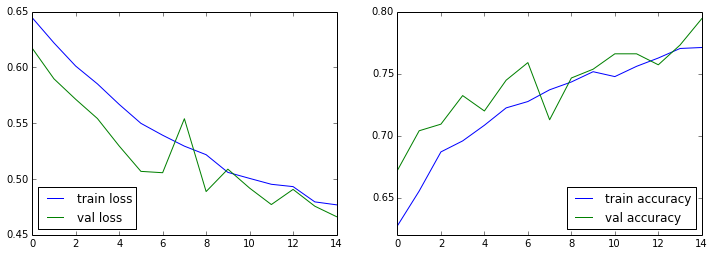

In [15]:
if True:
    history = model.fit(
        X_train, Y_train_binary,
        batch_size=32,
        validation_data=(X_test, Y_test_binary),
        nb_epoch=15
    )
    
    pl.figure(figsize=(12, 4))
    pl.subplot(121)
    pl.plot(history.history['loss'], label='train loss')
    pl.plot(history.history['val_loss'], c='g', label='val loss')
    pl.legend(loc='lower left')

    pl.subplot(122)
    pl.plot(history.history['acc'], label='train accuracy')
    pl.plot(history.history['val_acc'], c='g', label='val accuracy')
    pl.legend(loc='lower right')
else:
    model = load_boolean_cnn()

In [16]:
if False:
    model_dir = '../../models/cnn_predict_boolean'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights.h5'))

In [17]:
def predict(X):
     return (model.predict(X) > 0.5).squeeze()
Y_pred = predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score
print "test set score : ", accuracy_score(Y_test_binary, Y_pred)

test set score :  0.789007092199


# Chain binary cnn + fcnn

In [ ]:
# TODO
fcnn = load_fcnn()

# Run the model on kaggle'7 test set

In [32]:
_d = np.load('../../data_test.npz')
X_submit = _d['X']
test_fnames = _d['test_fnames']
Y_pred = predict(X_submit[:,None,:,:])

In [34]:
print Y_pred.shape
print np.count_nonzero(Y_pred)

(5508,)
1842


# Run the FCNN on the test examples which are predicted positively

In [ ]:
OUTDIR='../../preds'
if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
utils.mkdir_p(OUTDIR)

for i in range(Y_pred.shape[0]):
    imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
    basename = os.path.splitext(test_fnames[i])[0]
    cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)

# Visualization stuff

In [ ]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
# Visualize weights
W = model.layers[1].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

mosaic = make_mosaic(W, 6, 6)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), mosaic, cmap=cm.gray)

In [ ]:
def find_layer(name):
    for l in model.layers:
        if l.name == name:
            return l
    else:
        return None
find_layer('pool1')

In [ ]:
from keras import backend as K

def visualize_layer(lname, X):

    # K.learning_phase() is a flag that indicates if the network is in training or
    # predict phase. It allow layer (e.g. Dropout) to only be applied during training
    inputs = [K.learning_phase()] + model.inputs

    _f = K.function(inputs, [find_layer(lname).output])
    def f(X):
        # The [0] is to disable the training phase flag
        return _f([0] + [X])
    
    # Visualize convolution result (after activation)
    C1 = f(X)
    C1 = np.squeeze(C1)
    print("C1 shape : ", C1.shape)

    pl.figure(figsize=(10, 8))
    nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)
    
#visualize_layer('pool1', X_test[i][None, :, :, :])
visualize_layer('pool3', X_test[i][None, :, :, :])

In [ ]:
# CPU chunked version
import sys

if False
    batch_size = 32
    for epoch in range(5):
        order = np.arange(X_train.shape[0])
        np.random.shuffle(order)
        for i in range(0, len(order), batch_size):
            indices = order[i:i+batch_size]
            _X_train = X_train[indices]
            _Y_train = Y_train[indices]
            history = model.fit(_X_train, _Y_train, nb_epoch=1)
            print history
            sys.stdout.flush()